## Facies classification using Random Forest


### Contest entry by <a href=\"https://geolern.github.io/index.html#\">geoLEARN</a>:


##### <a href=\"https://github.com/mablou\">Martin Blouin</a>,  <a href=\"https://github.com/lperozzi\">Lorenzo Perozzi</a> and <a href=\"https://github.com/Antoine-Cate\">Antoine Caté</a> <br> 
in collaboration with <a href=\"http://ete.inrs.ca/erwan-gloaguen\">Erwan Gloaguen</a>


####  [Original contest notebook](../Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/)

In this notebook we will train a machine learning algorithm to predict facies from well log data.  The dataset comes from a class exercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011).

The dataset consists of log data from nine wells that have been labeled with a facies type based on observation of core. We will use this log data to train a Random Forest model to classify facies types. 

## Exploring the dataset

First, we import and examine the dataset used to train the classifier.

In [25]:
###### Importing all used packages
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

###### Import packages needed for the make_vars functions
import Feature_Engineering as FE

##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score,LeavePGroupsOut, LeaveOneGroupOut, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score

filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [2]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


A complete description of the dataset is given in the  [Original contest notebook](../Facies_classification.ipynb) by Brendon Hall, [Enthought](https://www.enthought.com/). A total of four measured rock properties and two interpreted geological properties are given as raw predictor variables for the prediction of the "Facies" class.

## Feature engineering
As stated in our [previous submission](Submission_increased_variance.ipynb), we believe that feature engineering has a high potential for increasing classification success. A strategy for building new variables is explained below.

The dataset is distributed along a series of drillholes intersecting a stratigraphic sequence. Sedimentary facies tend to be deposited in sequences that reflect the evolution of the paleo-environment (variations in water depth, water temperature, biological activity, currents strenght, detrital input, ...). Each facies represents a specific depositional environment and is in contact with facies that represent a progressive transition to an other environment.
Thus, there is a relationship between neighbouring samples, and the distribution of the data along drillholes can be as important as data values for predicting facies.

A series of new variables (features) are calculated and tested below to help represent the relationship of neighbouring samples and the overall texture of the data along drillholes. These variables are:

- detail and approximation coeficients at various levels of two [wavelet transforms](https://en.wikipedia.org/wiki/Discrete_wavelet_transform) (using two types of [Daubechies](https://en.wikipedia.org/wiki/Daubechies_wavelet) wavelets);
- measures of the local entropy with variable observation windows;
- measures of the local gradient with variable observation windows;
- rolling statistical calculations (i.e., mean, standard deviation, min and max) with variable observation windows;
- ratios between marine and non-marine lithofacies with different observation windows;
- distances from the nearest marine or non-marine occurence uphole and downhole.

Functions used to build these variables are located in the [Feature Engineering](Feature_Engineering.py) python script.

All the data exploration work related to the conception and study of these variables is not presented here.

In [3]:
##### cD From wavelet db1
dwt_db1_cD_df = FE.make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')

##### cA From wavelet db1
dwt_db1_cA_df = FE.make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')

##### cD From wavelet db3
dwt_db3_cD_df = FE.make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')

##### cA From wavelet db3
dwt_db3_cA_df = FE.make_dwt_vars_cA(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')

##### From entropy
entropy_df = FE.make_entropy_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                               l_foots=[2, 3, 4, 5, 7, 10])

###### From gradient
gradient_df = FE.make_gradient_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                 dx_list=[2, 3, 4, 5, 6, 10, 20])

##### From rolling average
moving_av_df = FE.make_moving_av_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                   windows=[1, 2, 5, 10, 20])

##### From rolling standard deviation
moving_std_df = FE.make_moving_std_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3 , 4, 5, 7, 10, 15, 20])

##### From rolling max
moving_max_df = FE.make_moving_max_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3, 4, 5, 7, 10, 15, 20])

##### From rolling min
moving_min_df = FE.make_moving_min_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3 , 4, 5, 7, 10, 15, 20])

###### From rolling NM/M ratio
rolling_marine_ratio_df = FE.make_rolling_marine_ratio_vars(wells_df=training_data, windows=[5, 10, 15, 20, 30, 50, 75, 100, 200])

###### From distance to NM and M, up and down
dist_M_up_df = FE.make_distance_to_M_up_vars(wells_df=training_data)
dist_M_down_df = FE.make_distance_to_M_down_vars(wells_df=training_data)
dist_NM_up_df = FE.make_distance_to_NM_up_vars(wells_df=training_data)
dist_NM_down_df = FE.make_distance_to_NM_down_vars(wells_df=training_data)

In [4]:
list_df_var = [dwt_db1_cD_df, dwt_db1_cA_df, dwt_db3_cD_df, dwt_db3_cA_df,
               entropy_df, gradient_df, moving_av_df, moving_std_df, moving_max_df, moving_min_df,
              rolling_marine_ratio_df, dist_M_up_df, dist_M_down_df, dist_NM_up_df, dist_NM_down_df]
combined_df = training_data
for var_df in list_df_var:
    temp_df = var_df
    combined_df = pd.concat([combined_df,temp_df],axis=1)
combined_df.replace(to_replace=np.nan, value='-1', inplace=True)
print (combined_df.shape)
combined_df.head(5)

(4149, 299)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,Marine_ratio_20_centered,Marine_ratio_30_centered,Marine_ratio_50_centered,Marine_ratio_75_centered,Marine_ratio_100_centered,Marine_ratio_200_centered,dist_M_up,dist_M_down,dist_NM_up,dist_NM_down
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,...,1.0,1.0,1.0,1.0,1.140000,1.510000,-1.0,21.5,0.0,0.0
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,...,1.0,1.0,1.0,1.0,1.156863,1.504950,-1.0,21.0,0.0,0.0
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,...,1.0,1.0,1.0,1.0,1.173077,1.500000,-1.0,20.5,0.0,0.0
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,...,1.0,1.0,1.0,1.0,1.188679,1.495146,-1.0,20.0,0.0,0.0
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,...,1.0,1.0,1.0,1.0,1.203704,1.490385,-1.0,19.5,0.0,0.0


## Building a prediction model from these variables

A Random Forest model is built here to test the effect of these new variables on the prediction power. Algorithm parameters have been tuned so as to take into account the non-stationarity of the training and testing sets using the LeaveOneGroupOut cross-validation strategy. The size of individual tree leafs and nodes has been increased to the maximum possible without significantly increasing the variance so as to reduce the bias of the prediction.
Box plot for a series of scores obtained through cross validation are presented below.

###### Create predictor and target arrays

In [5]:
X = combined_df.iloc[:, 4:]
y = combined_df['Facies']
groups = combined_df['Well Name']

###### Estimation of validation scores from this tuning

In [6]:
scoring_param = ['accuracy', 'recall_weighted', 'precision_weighted','f1_weighted']
scores = []

Cl = RandomForestClassifier(n_estimators=100, max_features=0.1, min_samples_leaf=25,
                            min_samples_split=50, class_weight='balanced', random_state=42, n_jobs=-1)

lpgo = LeavePGroupsOut(n_groups=2)

for scoring in scoring_param:
    
    cv=lpgo.split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=scoring_param)

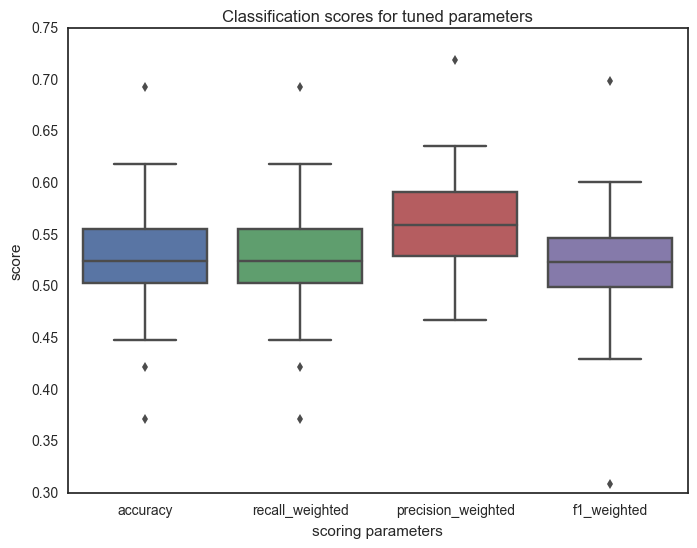

In [7]:
sns.set_style('white')
fig,ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=scores)
plt.xlabel('scoring parameters')
plt.ylabel('score')
plt.title('Classification scores for tuned parameters');

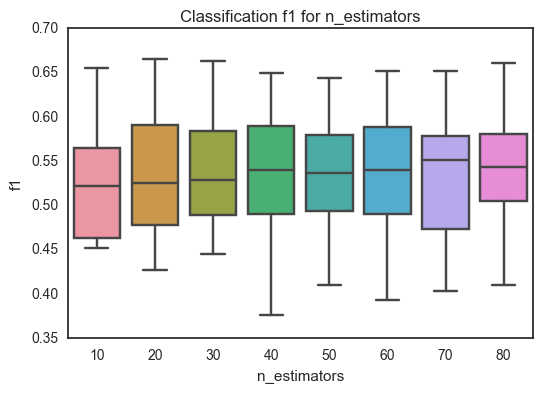

In [9]:
################ Testing accuracy with variable n_estimators 
rang = np.arange(10, 81, 10)
#rang = [5, 10, 15, 20, 50, 100]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=val, max_features = 1.0, subsample = 0.8)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('n_estimators')
plt.ylabel('f1')
plt.title('Classification f1 for n_estimators')
plt.show()

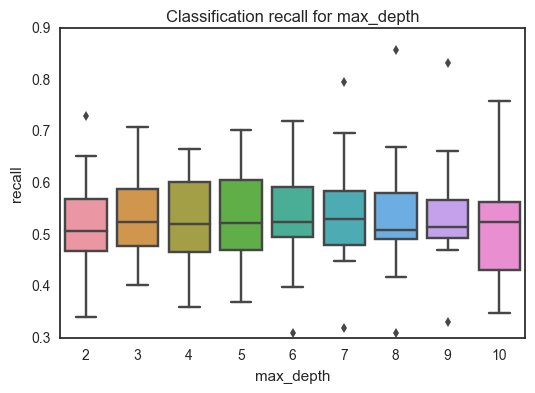

In [10]:
################ Tuning max_depth
rang = np.arange(2, 11, 1)
#rang = [2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=40, max_depth=val,
                                    max_features = 'sqrt', subsample = 0.8)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_depth')
plt.ylabel('recall')
plt.title('Classification recall for max_depth')
plt.show()

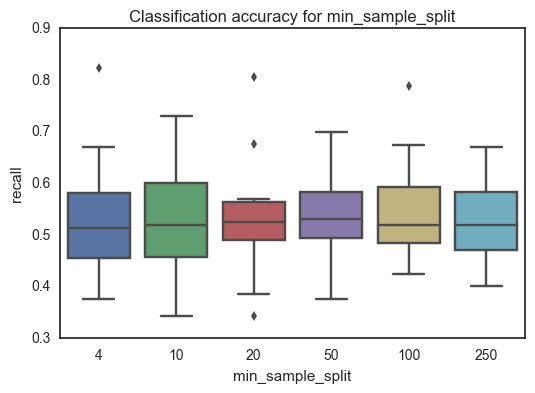

In [11]:
################ Tuning min_samples_split
#rang = np.arange(2, 41, 4)
rang = [4, 10, 20, 50, 100, 250]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=40, max_depth=7,
                                    min_samples_split=val, max_features = 'sqrt', subsample = 0.8)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('min_sample_split')
plt.ylabel('recall')
plt.title('Classification accuracy for min_sample_split')
plt.show()

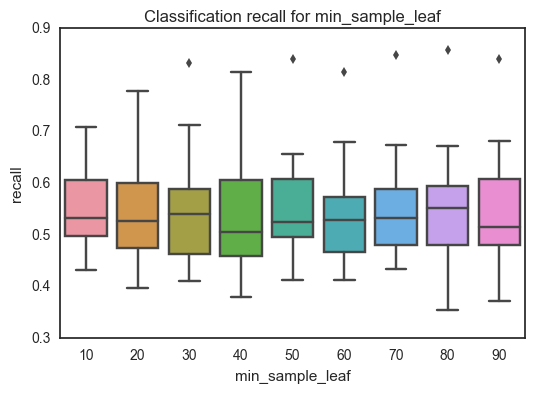

In [14]:
################ Tuning min_samples_leaf
rang = np.arange(10, 100, 10)
#rang = [2, 5, 10, 15, 25]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=40, max_depth=7,
                                    min_samples_split=100, min_samples_leaf=val, max_features = 'sqrt', subsample = 0.8)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('min_sample_leaf')
plt.ylabel('recall')
plt.title('Classification recall for min_sample_leaf')
plt.show()

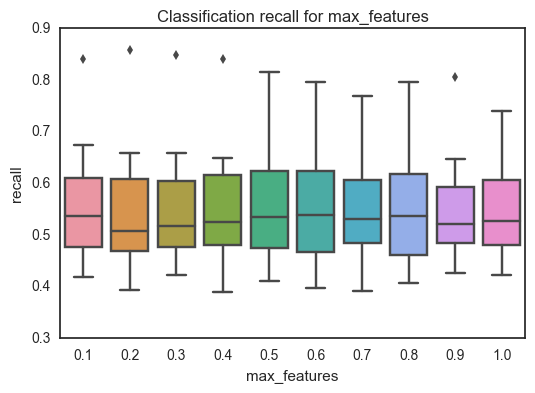

In [15]:
################ Tuning max_feature
rang = np.arange(0.1, 1.1, 0.1)
#rang = [2, 5, 10, 15, 25]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=40, max_depth=7,
                                    min_samples_split=100, min_samples_leaf=50, max_features = val, subsample = 0.8)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_features')
plt.ylabel('recall')
plt.title('Classification recall for max_features')
plt.show()

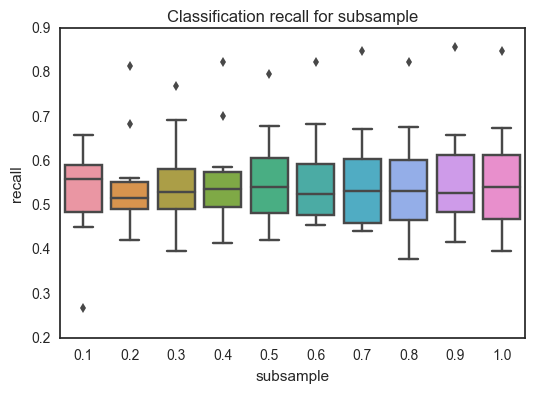

In [16]:
################ Tuning subsample
rang = np.arange(0.1, 1.1, 0.1)
#rang = [2, 5, 10, 15, 25]
scores = []

for val in rang:
    Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=40, max_depth=7,
                                    min_samples_split=100, min_samples_leaf=50, max_features = 0.1, subsample = val)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('subsample')
plt.ylabel('recall')
plt.title('Classification recall for subsample')
plt.show()

# Tuning hyper-parameters for f1_weighted
Best parameters set found on development set:
{'max_depth': 7, 'min_samples_split': 100, 'min_samples_leaf': 50, 'n_estimators': 100, 'loss': 'deviance', 'max_features': 0.1, 'subsample': 0.9, 'learning_rate': 0.1}
Score: 0.547



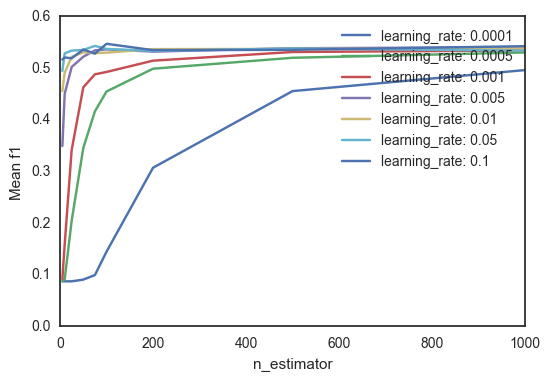

In [26]:
################ Tuning learning_rate and n_estimators

estimators_range = [5, 10, 25, 50, 75, 100, 200, 500, 1000]
learning_rate_range= [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
param_grid = dict(loss=['deviance'], n_estimators=estimators_range, learning_rate=learning_rate_range, max_depth=[7],
                                    min_samples_split = [100], min_samples_leaf = [50], max_features = [0.1], subsample = [0.9])
Cl=GradientBoostingClassifier()
# scoring options: ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'log_loss', 'mean_squared_error', 'precision', 'r2', 'recall', 'roc_auc'] 
print("# Tuning hyper-parameters for f1_weighted")
print("Best parameters set found on development set:")
cv = LeaveOneGroupOut().split(X, y, groups)
grid = GridSearchCV(Cl, param_grid, cv=cv, scoring='f1_weighted')
clf = grid.fit(X, y)
print(clf.best_params_)
print("Score: %0.03f" % clf.best_score_)
print("")
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(learning_rate_range), len(estimators_range))
for ind, i in enumerate(learning_rate_range):
    plt.plot(estimators_range, scores[ind], label='learning_rate: ' + str(i))
plt.legend()
plt.xlabel('n_estimator')
plt.ylabel('Mean f1')
plt.show()

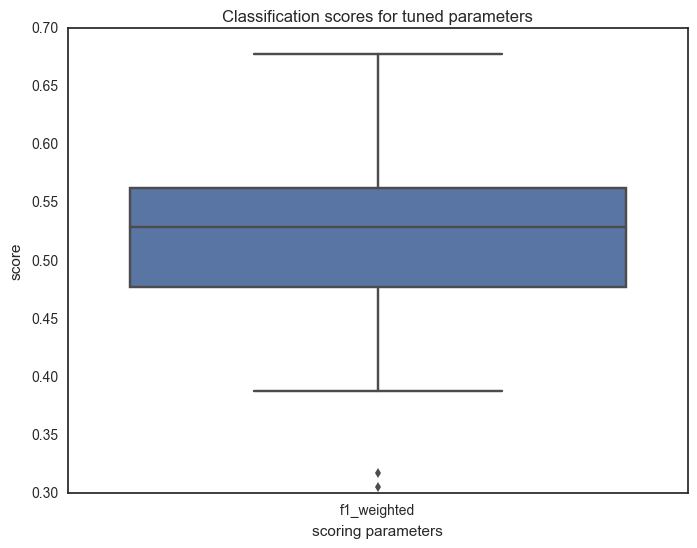

In [29]:
scoring_param = ['f1_weighted']
scores = []

Cl = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=200, max_depth=7,
                                    min_samples_split=100, min_samples_leaf=50, max_features = 0.1, subsample = 0.9)

lpgo = LeavePGroupsOut(n_groups=2)

for scoring in scoring_param:
    
    cv=lpgo.split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=scoring_param)
sns.set_style('white')
fig,ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=scores)
plt.xlabel('scoring parameters')
plt.ylabel('score')
plt.title('Classification scores for tuned parameters');

## Extra Trees

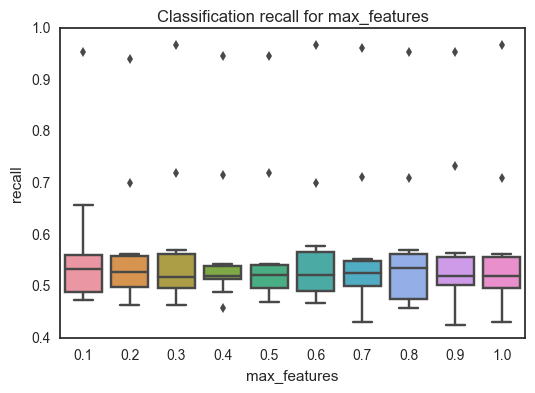

In [22]:
################ Tuning max_feature
rang = np.arange(0.1, 1.1, 0.1)
#rang = [2, 5, 10, 15, 25]
scores = []

for val in rang:
    Cl = ExtraTreesClassifier(n_estimators=250, min_samples_split=100, max_features = val, class_weight='balanced', n_jobs=-1)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('max_features')
plt.ylabel('recall')
plt.title('Classification recall for max_features')
plt.show()

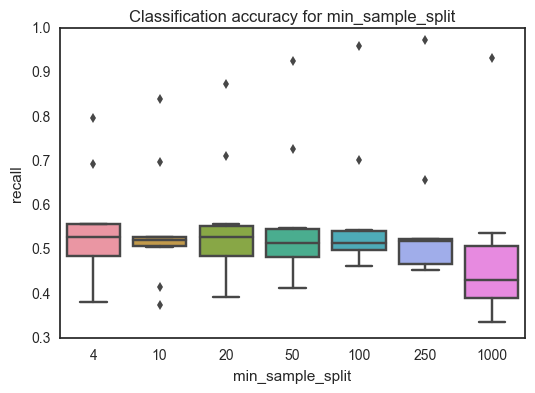

In [21]:
################ Tuning min_samples_split
#rang = np.arange(2, 41, 4)
rang = [4, 10, 20, 50, 100, 250, 1000]
scores = []

for val in rang:
    Cl = ExtraTreesClassifier(n_estimators=250, min_samples_split=val, max_features = 0.6, class_weight='balanced', n_jobs=-1)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('min_sample_split')
plt.ylabel('recall')
plt.title('Classification accuracy for min_sample_split')
plt.show()

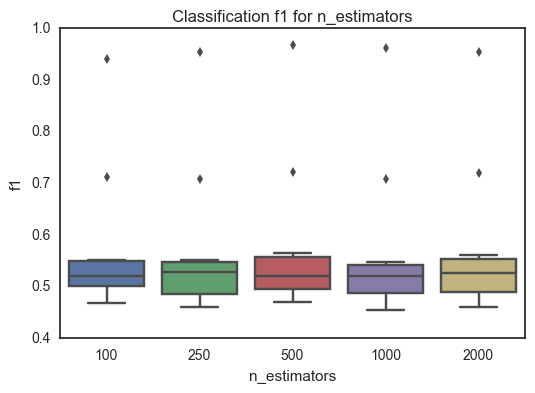

In [23]:
################ Testing accuracy with variable n_estimators 
#rang = np.arange(100, 2100, 100)
rang = [100, 250, 500, 1000, 2000]
scores = []

for val in rang:
    Cl = ExtraTreesClassifier(n_estimators=val, min_samples_split=100, max_features = 0.6, class_weight='balanced', n_jobs=-1)
    cv = LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring='f1_weighted', cv=cv)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=rang)
    
sns.boxplot(data=scores)

plt.xlabel('n_estimators')
plt.ylabel('f1')
plt.title('Classification f1 for n_estimators')
plt.show()

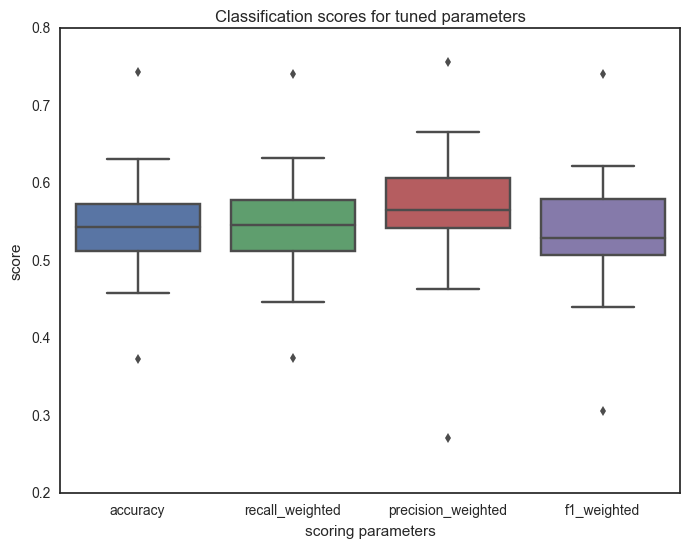

In [27]:
scoring_param = ['accuracy', 'recall_weighted', 'precision_weighted','f1_weighted']
scores = []

Cl = ExtraTreesClassifier(n_estimators=500, min_samples_split=100, max_features = 0.6, class_weight='balanced', n_jobs=-1)

lpgo = LeavePGroupsOut(n_groups=2)

for scoring in scoring_param:
    
    cv=lpgo.split(X, y, groups)
    validated = cross_val_score(Cl, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=scoring_param)
sns.set_style('white')
fig,ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=scores)
plt.xlabel('scoring parameters')
plt.ylabel('score')
plt.title('Classification scores for tuned parameters');

## Evaluating feature importances
The individual contribution to the classification for each feature (i.e., feature importances) can be obtained from a Random Forest classifier. This gives a good idea of the classification power of individual features and helps understanding which type of feature engineering is the most promising.

Caution should be taken when interpreting feature importances, as highly correlated variables will tend to dilute their classification power between themselves and will rank lower than uncorelated variables.

In [11]:
####### Evaluation of feature importances
Cl = RandomForestClassifier(n_estimators=75, max_features=0.1, min_samples_leaf=25,
                            min_samples_split=50, class_weight='balanced', random_state=42,oob_score=True, n_jobs=-1)
Cl.fit(X, y)
print ('OOB estimate of accuracy for prospectivity classification using all features: %s' % str(Cl.oob_score_))

importances = Cl.feature_importances_ 
std = np.std([tree.feature_importances_ for tree in Cl.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
Vars = list(X.columns.values)
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], Vars[indices[f]], importances[indices[f]]))

OOB estimate of accuracy for prospectivity classification using all features: 0.723065798988
Feature ranking:
1. feature 282 Marine_ratio_5_centered (0.031530)
2. feature 293 dist_NM_up (0.030115)
3. feature 288 Marine_ratio_75_centered (0.029691)
4. feature 292 dist_M_down (0.027875)
5. feature 284 Marine_ratio_15_centered (0.027651)
6. feature 285 Marine_ratio_20_centered (0.026680)
7. feature 290 Marine_ratio_200_centered (0.026423)
8. feature 286 Marine_ratio_30_centered (0.022103)
9. feature 5 NM_M (0.021090)
10. feature 289 Marine_ratio_100_centered (0.018909)
11. feature 287 Marine_ratio_50_centered (0.017506)
12. feature 283 Marine_ratio_10_centered (0.016424)
13. feature 171 PE_moving_av_20ft (0.014572)
14. feature 249 GR_moving_min_5ft (0.012678)
15. feature 291 dist_M_up (0.011630)
16. feature 250 GR_moving_min_7ft (0.011605)
17. feature 81 PE_cA_level_3 (0.010347)
18. feature 254 ILD_log10_moving_min_3ft (0.009445)
19. feature 272 PE_moving_min_10ft (0.009424)
20. feature 2

##### Plot the feature importances of the forest

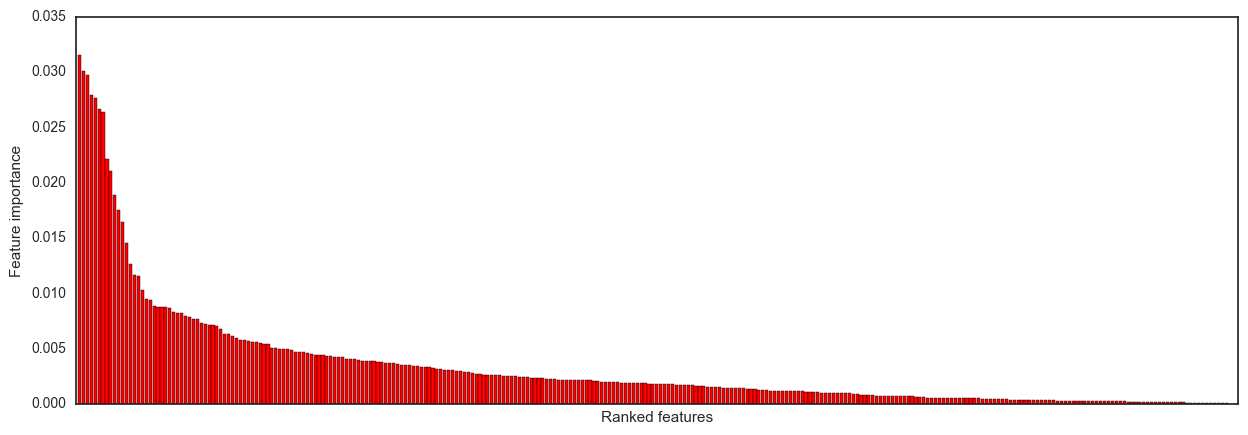

In [12]:
sns.set_style('white')
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(range(X.shape[1]), importances[indices],color="r", align="center")
plt.ylabel("Feature importance")
plt.xlabel('Ranked features')
plt.xticks([], indices)
plt.xlim([-1, X.shape[1]]);

Features derived from raw geological variables tend to have the highest classification power. Rolling min, max and mean tend to have better classification power than raw data. Wavelet approximation coeficients tend to have a similar to lower classification power than raw data. Features expressing local texture of the data (entropy, gradient, standard deviation and wavelet detail coeficients) have a low classification power but still participate in the prediction.

## Confusion matrix
The confusion matrix from the validation test is presented below.

In [13]:
######## Confusion matrix from this tuning
cv=LeaveOneGroupOut().split(X, y, groups)
y_pred = cross_val_predict(Cl, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
list_facies = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
conf_mat = pd.DataFrame(conf_mat, columns=list_facies, index=list_facies)
conf_mat.head(10)

,SS,CSiS,FSiS,SiSh,MS,WS,D,PS,BS
SS,170,78,20,0,0,0,0,0,0
CSiS,77,604,254,3,0,2,0,0,0
FSiS,25,255,484,8,0,2,1,5,0
SiSh,0,2,3,177,25,38,18,8,0
MS,0,3,9,53,30,105,26,50,20
WS,0,0,4,71,86,225,35,150,11
D,0,0,1,16,3,9,77,35,0
PS,0,4,11,35,15,159,73,341,48
BS,0,2,0,0,1,13,15,54,100


## Applying the classification model to test data

In [15]:
filename = '../validation_data_nofacies.csv'
test_data = pd.read_csv(filename)
test_data.head(5)

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911


In [16]:
##### cD From wavelet db1
dwt_db1_cD_df = FE.make_dwt_vars_cD(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                    levels=[1, 2, 3, 4], wavelet='db1')

##### cA From wavelet db1
dwt_db1_cA_df = FE.make_dwt_vars_cA(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db1')

##### cD From wavelet db3
dwt_db3_cD_df = FE.make_dwt_vars_cD(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')

##### cA From wavelet db3
dwt_db3_cA_df = FE.make_dwt_vars_cA(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')

##### From entropy
entropy_df = FE.make_entropy_vars(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                               l_foots=[2, 3, 4, 5, 7, 10])

###### From gradient
gradient_df = FE.make_gradient_vars(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                 dx_list=[2, 3, 4, 5, 6, 10, 20])

##### From rolling average
moving_av_df = FE.make_moving_av_vars(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                   windows=[1, 2, 5, 10, 20])

##### From rolling standard deviation
moving_std_df = FE.make_moving_std_vars(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3 , 4, 5, 7, 10, 15, 20])

##### From rolling max
moving_max_df = FE.make_moving_max_vars(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3, 4, 5, 7, 10, 15, 20])

##### From rolling min
moving_min_df = FE.make_moving_min_vars(wells_df=test_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                     windows=[3 , 4, 5, 7, 10, 15, 20])

###### From rolling NM/M ratio
rolling_marine_ratio_df = FE.make_rolling_marine_ratio_vars(wells_df=test_data, windows=[5, 10, 15, 20, 30, 50, 75, 100, 200])

###### From distance to NM and M, up and down
dist_M_up_df = FE.make_distance_to_M_up_vars(wells_df=test_data)
dist_M_down_df = FE.make_distance_to_M_down_vars(wells_df=test_data)
dist_NM_up_df = FE.make_distance_to_NM_up_vars(wells_df=test_data)
dist_NM_down_df = FE.make_distance_to_NM_down_vars(wells_df=test_data)

In [17]:
combined_test_df = test_data
list_df_var = [dwt_db1_cD_df, dwt_db1_cA_df, dwt_db3_cD_df, dwt_db3_cA_df,
               entropy_df, gradient_df, moving_av_df, moving_std_df, moving_max_df, moving_min_df,
              rolling_marine_ratio_df, dist_M_up_df, dist_M_down_df, dist_NM_up_df, dist_NM_down_df]
for var_df in list_df_var:
    temp_df = var_df
    combined_test_df = pd.concat([combined_test_df,temp_df],axis=1)
combined_test_df.replace(to_replace=np.nan, value='-99999', inplace=True)

X_test = combined_test_df.iloc[:, 3:]

print (combined_test_df.shape)
combined_test_df.head(5)

(830, 298)


,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,...,Marine_ratio_20_centered,Marine_ratio_30_centered,Marine_ratio_50_centered,Marine_ratio_75_centered,Marine_ratio_100_centered,Marine_ratio_200_centered,dist_M_up,dist_M_down,dist_NM_up,dist_NM_down
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,...,1.0,1.0,1.0,1.0,1.140000,1.570000,-1.0,21.5,0.0,0.0
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,...,1.0,1.0,1.0,1.0,1.156863,1.574257,-1.0,21.0,0.0,0.0
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,...,1.0,1.0,1.0,1.0,1.173077,1.578431,-1.0,20.5,0.0,0.0
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,...,1.0,1.0,1.0,1.0,1.188679,1.582524,-1.0,20.0,0.0,0.0
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,...,1.0,1.0,1.0,1.0,1.203704,1.586538,-1.0,19.5,0.0,0.0


In [18]:
Cl = RandomForestClassifier(n_estimators=100, max_features=0.1, min_samples_leaf=25,
                            min_samples_split=50, class_weight='balanced', random_state=42, n_jobs=-1)
Cl.fit(X, y)
y_test = Cl.predict(X_test)
y_test = pd.DataFrame(y_test, columns=['Predicted Facies'])
test_pred_df = pd.concat([combined_test_df[['Well Name', 'Depth']], y_test], axis=1)
test_pred_df.head()

,Well Name,Depth,Predicted Facies
0,STUART,2808.0,3
1,STUART,2808.5,3
2,STUART,2809.0,3
3,STUART,2809.5,3
4,STUART,2810.0,3


## Exporting results

In [19]:
test_pred_df.to_pickle('Prediction_blind_wells_RF_c.pkl')